In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import iirdesign, iirfilter, freqs, tf2zpk
import math
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
plt.style.use('ggplot')
from matplotlib.figure import figaspect

1 [0.+8.20937722e+08j 0.-8.20937722e+08j 0.+3.40043538e+08j
 0.-3.40043538e+08j] [-3.86194718e+07+98966834.21040958j -3.86194718e+07-98966834.21040958j
 -1.01437669e+08+44599628.22395115j -1.01437669e+08-44599628.22395115j] 0.0017782794100389223


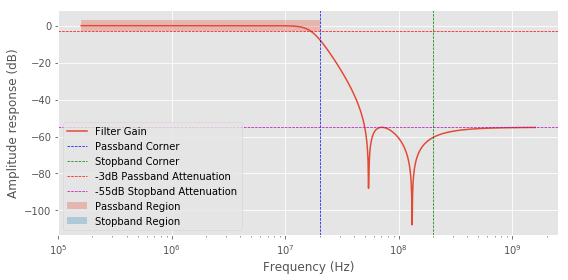

In [11]:
# Design a minimum order LPF of filter type 'ftype'.
# The function will increase the filter order until the stopband attenuation spec is met.
# passband_corner, stopband_corner in radians/sec
# stopband_atten should be positive in dBc
def design_lpf(passband_corner, stopband_corner, stopband_atten, passband_ripple, ftype='butter'):
    assert passband_ripple > 0, "Can't have 0 ripple in the passband"
    assert stopband_atten > 0, "Attenuation should be given as a positive number (-50dBc => stopband_atten = 50)"
    order = 1
    while True:
        b, a = iirfilter(
            N = 4,
            Wn = [passband_corner],
            rp = passband_ripple,
            rs = stopband_atten,
            btype = 'lowpass',
            analog = True,
            ftype=ftype,
            output='ba')
        w, h = freqs(b, a, worN=[stopband_corner])
        if (-20*np.log10(abs(h[0])) > stopband_atten):
            return order, b, a
        else:
            order = order + 1

order, b, a = design_lpf(2*math.pi*50e6, 2*math.pi*200e6, 55, 1, ftype='cheby2')
w, h = freqs(b, a, worN=np.logspace(6, 10, 1000))
f = w / (2*math.pi)
db = 20*np.log10(abs(h))
width, height = figaspect(0.5)
fig, ax = plt.subplots(figsize=(width,height))
plt.semilogx(f, db, linewidth=1.5)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude response (dB)')
plt.axvline(x=20e6, linestyle = '--', linewidth=0.7, color='b')
plt.axvline(x=200e6, linestyle = '--', linewidth=0.7, color='g')
plt.axhline(y=-3, linestyle = '--', linewidth=0.7, color='r')
plt.axhline(y=-55, linestyle = '--', linewidth=0.7, color='m')
plt.grid(True)
ax.fill([f[0], 20e6, 20e6, f[0]], [3, 3, -3, -3], alpha=0.3)
ax.fill([200e6, f[-1], f[-1], 200e6], [-55, -55, db[-1], db[-1]], alpha=0.3)
plt.legend(['Filter Gain', 'Passband Corner', 'Stopband Corner', '-3dB Passband Attenuation',
            '-55dB Stopband Attenuation', 'Passband Region', 'Stopband Region'])
plt.tight_layout()
plt.savefig('plot.pdf')
z, p, k = tf2zpk(b, a)
print(order, z, p, k)

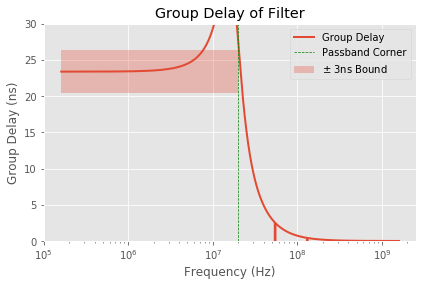

In [12]:
group_delay = (-np.diff(np.unwrap(np.angle(h))) / np.diff(w)) * 1e9
width, height = figaspect(0.6)
fig, ax = plt.subplots(figsize=(width,height))
plt.semilogx(f[1:], group_delay, linewidth=2)
plt.axvline(x=20e6, linestyle = '--', linewidth=0.7, color='g')
ax.fill([f[0], 20e6, 20e6, f[0]], [group_delay[0] + 3, group_delay[0] + 3, group_delay[0] - 3, group_delay[0] - 3],
        alpha=0.3)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Group Delay (ns)')
plt.title('Group Delay of Filter')
plt.legend(['Group Delay', 'Passband Corner', '$\pm$ 3ns Bound'])
plt.ylim(0, 30)
plt.show()